<img style="float: left; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="400" height="500" /> 
    
    
### <font color='navy'> Modelos no lineales para pronósticos. 

**Nombres:** Andre Gonzalez, Rafael Juarez Badillo

**Fecha:** 15 de febrero del 2024.

**Expediente** : 739922, #####
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Andr3Glez/Proyecto_conjunto3_RAJuarez_ANGonzalez

# Tarea 3: Análisis problema práctico.

# <font color= Red> Tarea 3

Condensar todos los procedimientos realizados en esta clase donde se implementen los métodos necesarios para crear un correcto flujo de lectura de datos, análisis, ajuste de parámetros, predicción y métricas de errores para un conjunto de datos dado. Algo como lo siguiente:

In [ ]:
class LinearForecast:
    def __init__(self, atributos_del_contructor):
        
    def adf_test(self):
        
    def plot_acf_pac(self):
        
        .
        .
        .

Implementar los métodos y las lógicas que consideren pertinentes, como de igual forma las posibles variables a introducir en el constructor de la clase.

Posteriormente, utilizar la clase anteriormente creada para generar un modelo SARIMAX para el siguiente conjunto de datos:
https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true

Código de solución estudiante 1 Andre Gonzalez

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import MSTL
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels as st
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import boxcox, yeojohnson

import itertools
import warnings 
warnings.filterwarnings("ignore")

In [14]:
data = pd.read_excel('https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true')
data.head()

,Unnamed: 0,date,year,month,day,hour,GHI (W/m2),DNI (W/m2),DHI (W/m2),Wet bulb temp (C),Dew point temp (C),Energy (kWh)
0,6,1990-01-01,1990,Jan,Mon,6,234,503,78,12.1406,9.7,498.632
1,7,1990-01-01,1990,Jan,Mon,7,448,723,91,13.3250,10.1,720.409
2,8,1990-01-01,1990,Jan,Mon,8,699,959,71,13.3094,9.3,946.154
3,9,1990-01-01,1990,Jan,Mon,9,880,1016,73,13.9375,9.1,987.273
4,10,1990-01-01,1990,Jan,Mon,10,1009,1031,85,14.1141,8.0,1000.230


In [15]:
# Nos quedamos solo con los datos que usaremos
data = data[['date','Energy (kWh)']]
data.head()

,date,Energy (kWh)
0,1990-01-01,498.632
1,1990-01-01,720.409
2,1990-01-01,946.154
3,1990-01-01,987.273
4,1990-01-01,1000.230


In [16]:
# disminuimos los datos usando la media
data = data.set_index('date').resample('M').mean()
data.head()

,Energy (kWh)
date,
1990-01-31,451.887005
1990-02-28,423.897505
1990-03-31,430.298776
1990-04-30,296.197605
1990-05-31,288.352006


In [17]:
class Forecast:
    def __init__(self, data):
        self.data = data

    def adf_test(self):
        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(self.data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")

    def acf_pacf(self, kwargs=dict()):
        f = plt.figure(figsize=(10,8))

        ax1 = f.add_subplot(121)

        plot_acf(self.data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(self.data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()

    def descomposicion(self):
        data1 = self.data.copy()
        
        #Elegimos 6 y 12 por los datos en meses
        periods_seasonality = (6, 12)

        stl_kwargs = {"seasonal_deg": 0}
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(10, 10))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')
        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')
        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')
        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')
        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')
        fig.tight_layout()
        
        return res2
        
    def split_trn_tst(self):
        train_data, test_data = train_test_split(data, test_size=0.2, random_state=0, shuffle=False)
        return train_data, test_data

    def eval_forecasts(actual, predicted):
            
        mse = mean_squared_error(actual, predicted)
        rmse = mean_squared_error(actual, predicted, squared=True)
        mad = mean_absolute_error(actual, predicted)
        mape = mean_absolute_percentage_error(actual, predicted)

        return mse, rmse, mad, mape
    
    def model_forecast(self, history, data, p, d, q, start, end, horizonte=0):
        arima_model = ARIMA(history, order=(p, d, q))
        model = arima_model.fit()
        print(model.summary())

        plt.figure(figsize=(10,10))
        model.plot_diagnostics()
        plt.show()
        model_func = model.predict(start=start, end=end + horizonte, dynamic=False).to_frame()
        ax = data.plot()
        model_func.plot(ax=ax)

        return model_func
    
    def eval_sarimax(self, sarimax_params):
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))
        i = 0
        for par_no_esta, par_esta, trend in sarimax_params[200:210]:
            mod = SARIMAX(
                endog=self.data,
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1

        self.evaluated = resultados
        return resultados

In [18]:
LinearForecast = Forecast(data)
LinearForecast.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


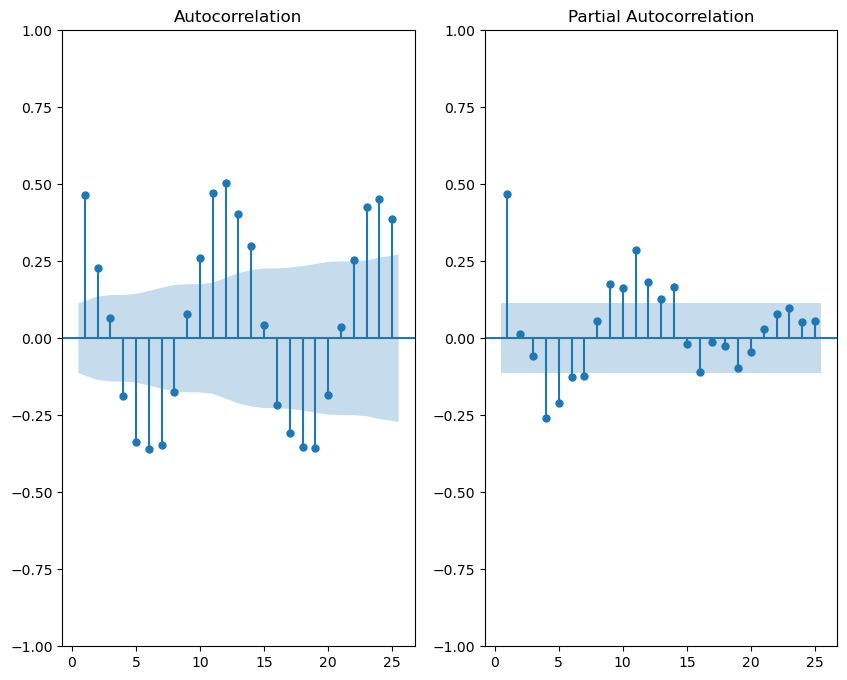

In [19]:
LinearForecast.acf_pacf()

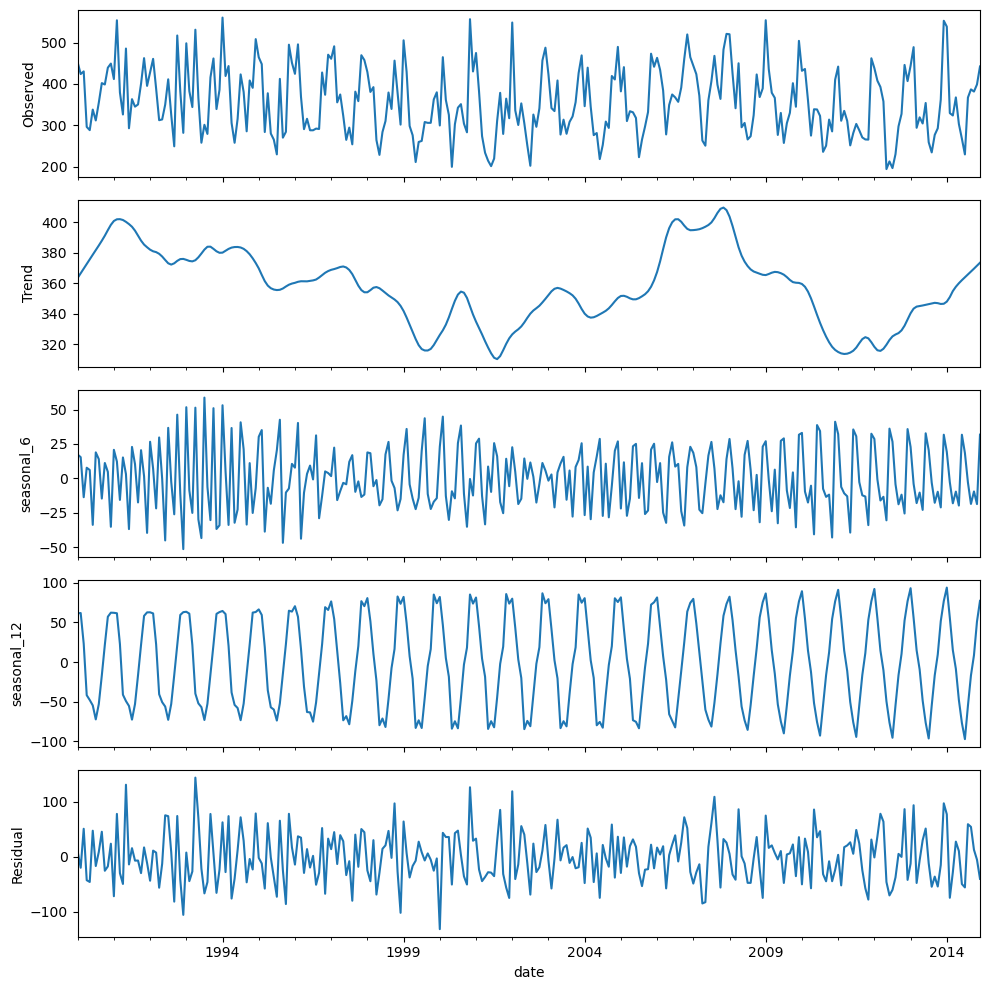

In [20]:
model = LinearForecast.descomposicion()

<Axes: xlabel='date'>

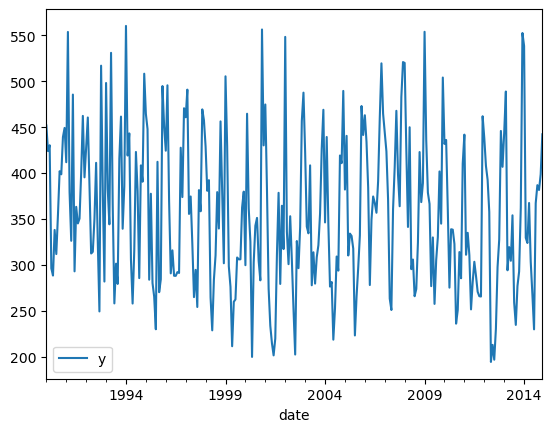

In [21]:
# Grafica con estacionalidad
model.observed.to_frame('y').plot()

<Axes: xlabel='date'>

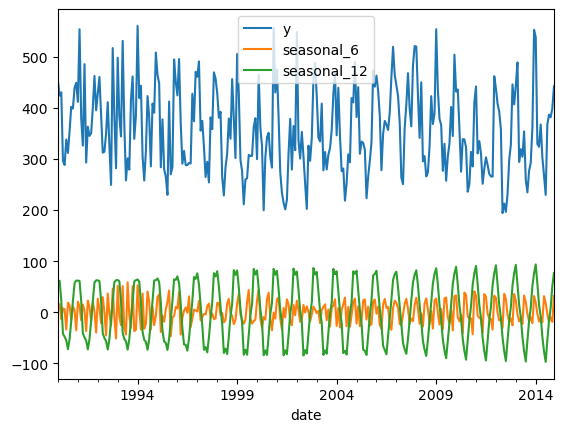

In [22]:
# Datos observados y Datos de estacionalidad
ax = model.observed.to_frame('y')[:400].plot()
model.seasonal[:400].plot(ax=ax)

In [23]:
seasonal_6 = model.seasonal['seasonal_6']
LinearForecast_2 = Forecast(seasonal_6)
LinearForecast_2.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -9.451841e+00
p-value                        4.594080e-16
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


In [24]:
LinearForecast_2_diff = Forecast(seasonal_6.diff().dropna())
LinearForecast_2_diff.adf_test()

Results of Dickey-Fuller Test:
Test Statistic                -1.483732e+01
p-value                        1.859822e-27
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


In [25]:
seasonal_12 = model.seasonal['seasonal_12']
LinearForecast_3 = Forecast(seasonality_12)
LinearForecast_3.adf_test()

NameError: name 'seasonality_12' is not defined

In [ ]:
LinearForecast_3_diff= Forecast(seasonality_12.diff().dropna())
LinearForecast_3_diff.adf_test()

In [ ]:
# Sin diferenciar
lf2.plot_acf_pacf()

In [ ]:
# Diferenciada
lf22.plot_acf_pacf()

In [ ]:
# Serie no estacional
noseasonal = model.observed - model.seasonal['seasonal_12']
noseasonal.plot()

In [ ]:
LinearForecast_4 = Forecast(noseasonal)
LinearForecast_4.adf_test()

In [ ]:
LinearForecast_4.acf_pacf()

In [ ]:
# parámetros
p = [0, 1, 2, 3, 4]
d = [1]
q = [0, 1, 2, 3]
P = [0, 1, 2]
D = [0,1]
Q = [0, 1, 2]
t = ['n', 'c', 't', 'ct']

In [ ]:
param_noEst = list(itertools.product(p, d, q))
param_est = [(x[0], x[1], x[2], 6) for x in list(itertools.product(P, D, Q))]
params_sarimax = list(itertools.product(param_noEst, param_est, t))
params_sarimax

In [ ]:
train, test = lf.split_dataset()
data['ln_y'] = np.log(train['Energy (kWh)'])

In [ ]:
LinearForecast = Forecast(train)
LinearForecast.eval_sarimax(params_sarimax)

El mejor modelo en base a la tabla es el primero con los parametros ((0, 1, 2), (2, 0, 2, 6), 'n'

Código de solución estudiante 1 Rafael Juarez

In [ ]:
url = 'https://github.com/quaesito/time-series-forecast-sarimax-prophet/blob/master/A4.xlsx?raw=true'

df = pd.read_excel(url)
    
df['date'] = df.apply(lambda x: x['date'] + pd.Timedelta(x['hour'], 'h'), axis = 1)
pd.to_datetime(df['date'])
df.drop(columns=['Unnamed: 0', 'year', 'month', 'day', 'hour'], inplace=True)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
df.rename(columns={'Energy (kWh)':'y'}, inplace=True)
df.head(3)

In [ ]:
class TimeSeriesAnalyzer:

    def __init__(self, data):
        self.data = data

    def defineTimeSeries(self):
        timeseries = df['y'].copy()
        timeseries =pd.DataFrame(timeseries)
        timeseries = timeseries.resample('M').mean()
        self.timeseries = timeseries
        return self.timeseries

    def plot_acf_pacf(self, diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=True, whatSeasonal='',kwargs={'lags': 40}):
        if wantSeasonal == True:
            if wantOberved == True:
                if wantNoSeasonal == True:
                    seasonality_data = self.res2.observed - self.res2.seasonal['seasonal_6'] - self.res2.seasonal['seasonal_12']
                else:
                    seasonality_data = self.res2.observed - self.res2.seasonal[whatSeasonal]
            else:
                seasonality_data = self.res2.seasonal[whatSeasonal][:400]
        else:
            seasonality_data = self.timeseries[:400]

        f = plt.figure(figsize=(8,5))

        for _ in range(diff):
            seasonality_data =seasonality_data.diff().dropna()

        ax1 = f.add_subplot(121)

        plot_acf(seasonality_data, zero=False, ax=ax1, **kwargs)

        ax2 = f.add_subplot(122)
        plot_pacf(seasonality_data, zero=False, ax=ax2, method='ols', **kwargs)

        plt.show()


    def stl_decomposition(self, periods_seasonality=(12, 24), stl_kwargs=dict()):
        data1 = self.timeseries
        model = MSTL(data1, periods=periods_seasonality, stl_kwargs=stl_kwargs)
        res2 = model.fit()

        # Gráfica de descomposición
        fig, ax = plt.subplots(5, 1, sharex=True, figsize=(8, 8))

        res2.observed.plot(ax=ax[0])
        ax[0].set_ylabel('Observed')

        res2.trend.plot(ax=ax[1])
        ax[1].set_ylabel('Trend')

        res2.seasonal[f'seasonal_{periods_seasonality[0]}'].plot(ax=ax[2])
        ax[2].set_ylabel(f'seasonal_{periods_seasonality[0]}')

        res2.seasonal[f'seasonal_{periods_seasonality[1]}'].plot(ax=ax[3])
        ax[3].set_ylabel(f'seasonal_{periods_seasonality[1]}')

        res2.resid.plot(ax=ax[4])
        ax[4].set_ylabel('Residual')

        fig.tight_layout()

        self.res2 = res2
        # Devolver gráficas y objeto MSTLResult
        return fig, res2
    
    def adf_test(self, diff, wantSeasonal=True,wantOberved=True,wantNoSeasonal = True, whatSeasonal=''):

        if wantSeasonal == True:
            if wantOberved == True:
                if wantNoSeasonal == True:
                    seasonality_data = self.res2.observed - self.res2.seasonal['seasonal_6'] - self.res2.seasonal['seasonal_12']
                else:
                    seasonality_data = self.res2.observed
                
            else:
                seasonality_data = self.res2.seasonal[whatSeasonal][:400]
        else:
            seasonality_data = self.timeseries

        for _ in range(diff):
            seasonality_data =seasonality_data.diff().dropna()

        print("Results of Dickey-Fuller Test:")
        dftest = adfuller(seasonality_data, autolag="AIC")
        dfoutput = pd.Series(
            dftest[0:4],
            index=[
                "Test Statistic",
                "p-value",
                "#Lags Used",
                "Number of Observations Used",
            ],
        )
        for key, value in dftest[4].items():
            dfoutput["Critical Value (%s)" % key] = value
        print(dfoutput)

        if (dftest[1] <= 0.05) & (dftest[4]['5%'] > dftest[0]):
            print("\u001b[32mStationary\u001b[0m")
        else:
            print("\x1b[31mNon-stationary\x1b[0m")
    
    @staticmethod
    def generate_sarimax_params(p, d, q, P, D, Q, t, seasonal_period=6):
        param_no_estacionales = list(itertools.product(p, d, q))
        param_estacionales = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(P, D, Q))]
        sarimax_params = list(itertools.product(param_no_estacionales, param_estacionales, t))
        return sarimax_params
    
    def split_and_transform(self, n_splits=3):

        # Separa los datos en conjuntos de entrenamiento y prueba
        y_train, y_test = train_test_split(self.timeseries, test_size=0.2, random_state=0, shuffle=False)

        y_train['log_y'] = np.log(y_train['y'])
        y_train['sqrt_y'] = np.sqrt(y_train['y'])
        y_train['boxcox_y'], self.lambda_boxcox = boxcox(y_train['y'])
        y_train['yeo_johnson_y'], self.lambda_yeojohnson = yeojohnson(y_train['y'])

        # Elimina los valores faltantes creados por las transformaciones box-cox y yeo-johnson
        y_train.dropna(inplace=True)

        self.y_train, self.y_test = y_train, y_test

        fig, ax = plt.subplots(1, 5, figsize=(10,4))

        y_train['y'].to_frame('y').boxplot(ax=ax[0])
        ax[0].set_title('Serie original')

        y_train['log_y'].to_frame('log_y').boxplot(ax=ax[1])

        ax[1].set_title('log_y')

        y_train['sqrt_y'].to_frame('sqrt_y').boxplot(ax=ax[2])

        ax[2].set_title('sqrt_y')

        y_train['boxcox_y'].to_frame('boxcox_y').boxplot(ax=ax[3])

        ax[3].set_title('boxcox_y')

        y_train['yeo_johnson_y'].to_frame('yeo_johnson_y').boxplot(ax=ax[4])

        ax[4].set_title('yeo_johnson_y')
        plt.show()

        return y_train, y_test, fig
        
    def evaluate_sarimax_params(self, sarimax_params, tansform=''):
        resultados = pd.DataFrame(columns=['params', 'AIC', 'BIC', 'LLF'], index=np.arange(0, 11))
        i = 0
        for par_no_esta, par_esta, trend in sarimax_params[200:220]:
            mod = SARIMAX(
                endog=self.y_train[tansform],
                trend=trend,
                order=par_no_esta,
                seasonal_order=par_esta
            )
            results = mod.fit(disp=False)

            resultados.loc[i, 'params'] = str((par_no_esta, par_esta, trend))
            resultados.loc[i, 'AIC'] = results.aic
            resultados.loc[i, 'BIC'] = results.bic
            resultados.loc[i, 'LLF'] = results.llf
            i += 1
        self.tansform = tansform
        self.evaluated = resultados
        return resultados
    
    def fit_predict_evaluate_plot(self, order=(), seasonal_order=(), trend=''):

        # Ajusta el modelo utilizando el conjunto de entrenamiento y una variable exógena
        mod = SARIMAX(
                endog=self.y_train[self.tansform],
                trend=trend,
                order=order,
                seasonal_order=seasonal_order
            )
        result = mod.fit(disp=False)

        # Hace predicciones utilizando el conjunto de prueba y una variable exógena
        predictions = result.predict(start=self.y_test.index[0], end=self.y_test.index[-1])

        # Evalúa el rendimiento del modelo utilizando el conjunto de prueba
        mae = (predictions - self.y_test['y']).abs().mean()
        mse = ((predictions - self.y_test['y']) ** 2).mean()

        # Grafica los datos reales y las predicciones
        plt.plot(self.y_train.index, self.y_train[self.tansform], label='Datos reales')
        plt.plot(predictions.index, predictions, label='Predicciones')
        plt.xlabel('Fecha')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()
        
        return mae, mse
        
tsa = TimeSeriesAnalyzer(df)
tsa.defineTimeSeries()

### Analisis de estacionalidad

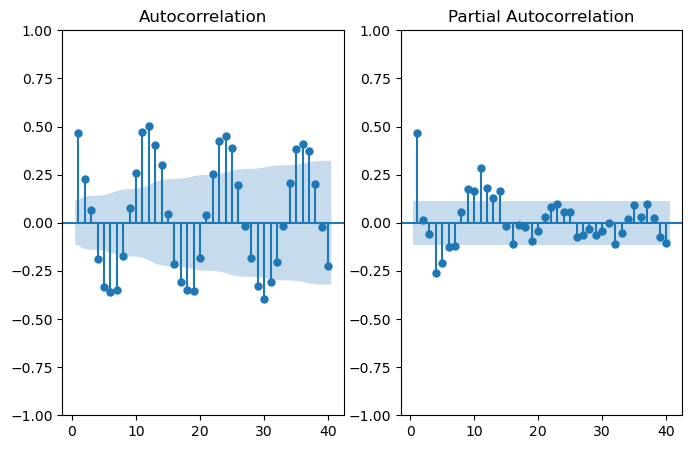

In [11]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=False,wantOberved=False,wantNoSeasonal=False, whatSeasonal='')

Parece que existe una estacionalidad, creo que esta en 6 y 12 meses

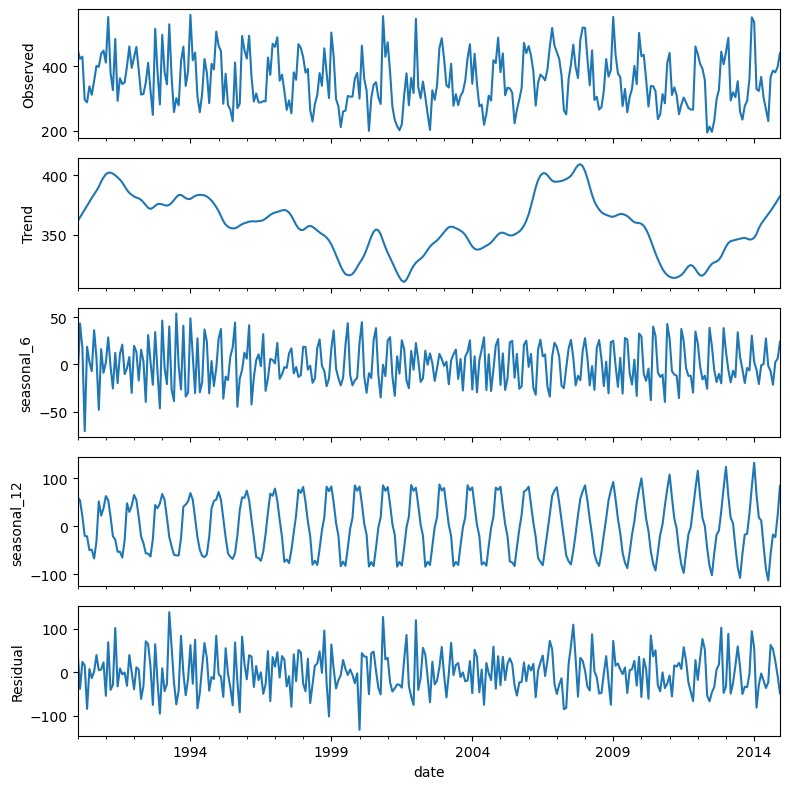

In [26]:
fig, res2 = tsa.stl_decomposition(periods_seasonality=(6, 12))

### Descomponer la serie de tiempo en las componentes estaciones detectadas.

<Axes: xlabel='date'>

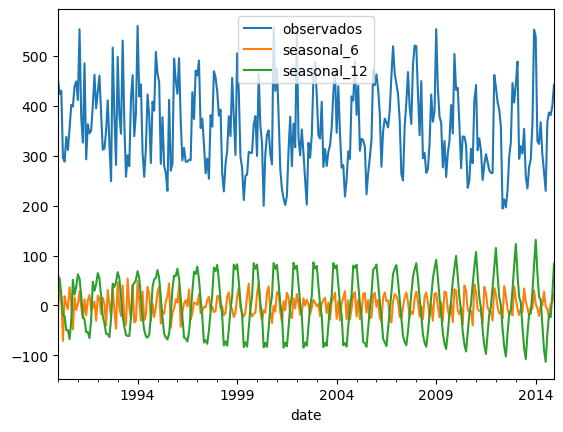

In [27]:
# Graficar datos observados con datos de estacionalidad
ax = res2.observed.to_frame('observados')[:400].plot()

res2.seasonal[:400].plot(ax=ax)

veamos si pasan la prueba

In [28]:
tsa.adf_test(diff=0,wantSeasonal=True,wantOberved=False,wantNoSeasonal = False,whatSeasonal='seasonal_12')

Results of Dickey-Fuller Test:
Test Statistic                 -35.110082
p-value                          0.000000
#Lags Used                      16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64
Stationary


In [29]:
tsa.adf_test(diff=0,wantSeasonal=True, wantOberved=False,wantNoSeasonal = False,whatSeasonal='seasonal_6')

Results of Dickey-Fuller Test:
Test Statistic                -9.741365e+00
p-value                        8.478448e-17
#Lags Used                     1.600000e+01
Number of Observations Used    2.830000e+02
Critical Value (1%)           -3.453670e+00
Critical Value (5%)           -2.871808e+00
Critical Value (10%)          -2.572241e+00
dtype: float64
Stationary


Las dos son estacionarias

### Determinar parámetros $(P,D,Q,S)$ 

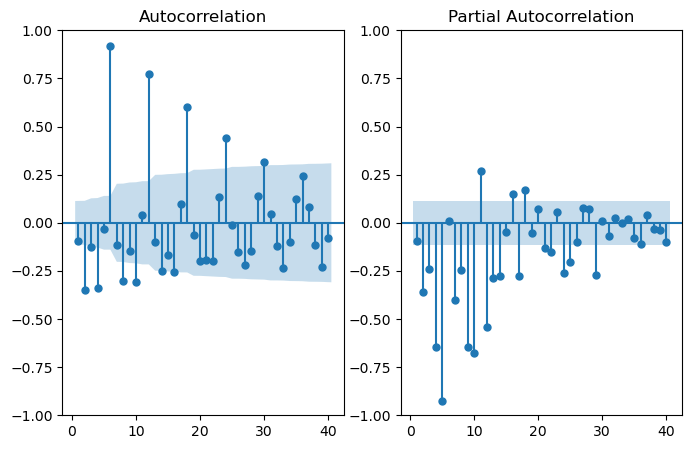

In [30]:
# Graficar ACF y PACF - > Analizar el caso cuando se diferencia la serie estacional seleccionada
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=False,wantNoSeasonal=False, whatSeasonal='seasonal_6')

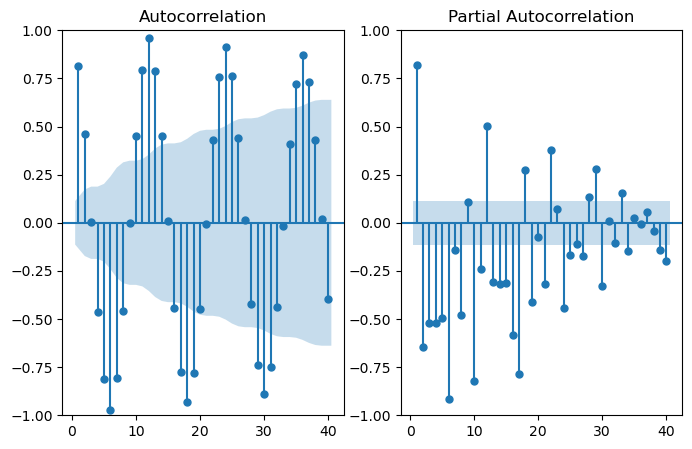

In [31]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=False, wantNoSeasonal=False,whatSeasonal='seasonal_12')

Parece que tenemos         
* P(0, 1, 2, 3, 4, 5)     
* D(0)
* Q(0, 1, 2)

### Componente no estacional $(p, d, q)$

In [32]:
tsa.adf_test(diff=0,wantSeasonal=True, wantOberved=True,wantNoSeasonal = False, whatSeasonal='')

Results of Dickey-Fuller Test:
Test Statistic                  -2.242267
p-value                          0.191264
#Lags Used                      13.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64
Non-stationary


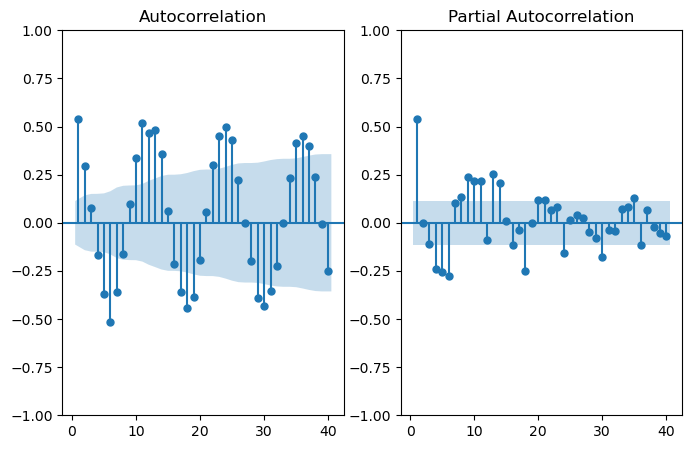

In [33]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=False, whatSeasonal='seasonal_6')

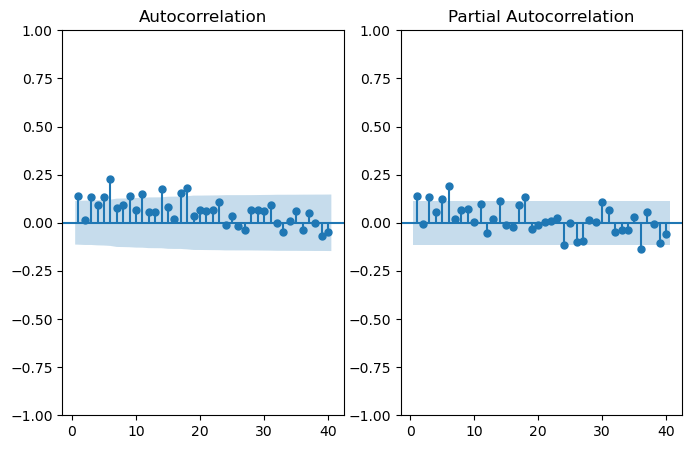

In [34]:
tsa.plot_acf_pacf(diff=0, wantSeasonal=True,wantOberved=True,wantNoSeasonal=False, whatSeasonal='seasonal_12')

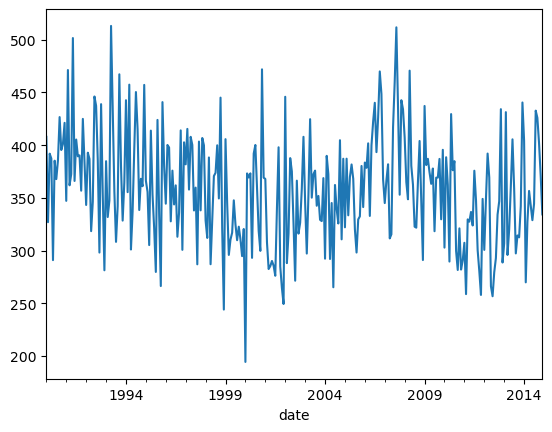

In [35]:
non_seasonal2 = res2.observed - res2.seasonal['seasonal_6'] - res2.seasonal['seasonal_12']

ax = non_seasonal2.plot()

plt.show()

In [36]:
tsa.adf_test(diff=1,wantSeasonal=True, wantOberved=True,wantNoSeasonal = True, whatSeasonal='')

Results of Dickey-Fuller Test:
Test Statistic                -5.958388e+00
p-value                        2.066936e-07
#Lags Used                     1.600000e+01
Number of Observations Used    2.820000e+02
Critical Value (1%)           -3.453754e+00
Critical Value (5%)           -2.871844e+00
Critical Value (10%)          -2.572261e+00
dtype: float64
Stationary


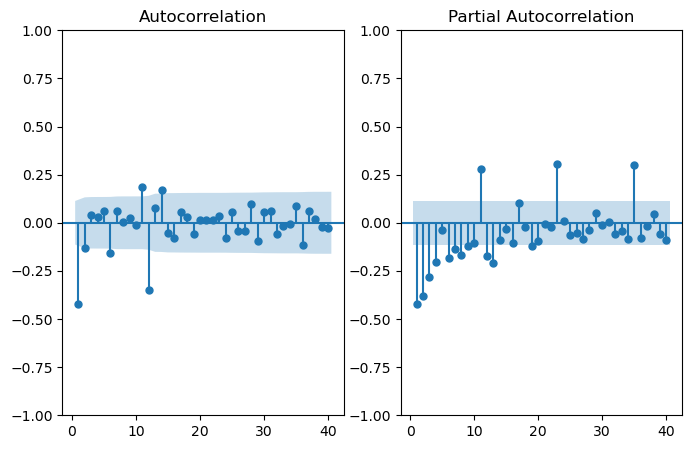

In [37]:
tsa.plot_acf_pacf(diff=1, wantSeasonal=True,wantOberved=True,wantNoSeasonal=True, whatSeasonal='')

Parece que tenemos
* p(0,1,2,3)
* d(0,1)
* q(0,1,2)

### Escalemos

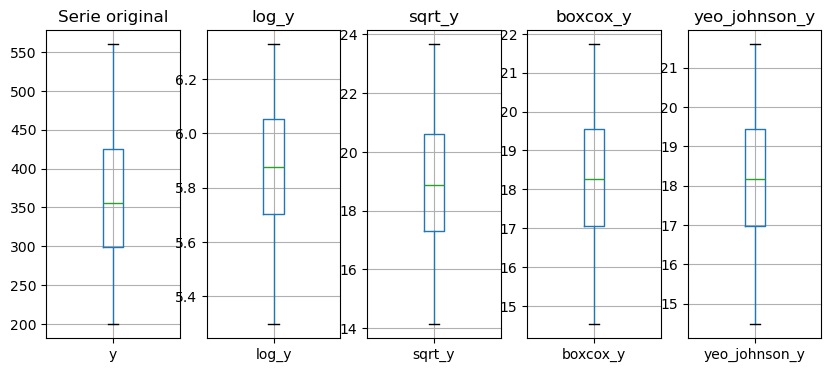

In [38]:
y_train, y_test, fig =tsa.split_and_transform()

### Eligiremos la boxcox_y

In [39]:
y_train

,y,log_y,sqrt_y,boxcox_y,yeo_johnson_y
date,,,,,
1990-01-31,451.887005,6.113432,21.257634,20.022907,19.903723
1990-02-28,423.897505,6.049492,20.588771,19.537377,19.423896
1990-03-31,430.298776,6.064480,20.743644,19.650262,19.535455
1990-04-30,296.197605,5.691027,17.210392,16.998974,16.915334
1990-05-31,288.352006,5.664182,16.980931,16.820808,16.739273
...,...,...,...,...,...
2009-08-31,305.111702,5.720678,17.467447,17.197628,17.111643
2009-09-30,330.127065,5.799478,18.169399,17.735206,17.642888
2009-10-31,401.772201,5.995885,20.044256,19.138218,19.029422


### Malla de parametros

In [40]:
sarimax_params = TimeSeriesAnalyzer.generate_sarimax_params(p=[0, 1,2,3], d=[0,1], q=[0, 1,2], 
                                                         P=[0, 1, 2,3,4,5], D=[0], Q=[0, 1, 2], 
                                                         t=['n', 'c', 't', 'ct'], seasonal_period=6)

### Con los datos escalados encontrar el conjunto más adecuado de parámetros

In [41]:
evaluated =tsa.evaluate_sarimax_params(sarimax_params,'log_y')

In [42]:
evaluated.sort_values(by=['AIC'], ascending=True)

,params,AIC,BIC,LLF
13,"((0, 0, 2), (5, 0, 2, 6), 'c')",-112.483997,-74.196969,67.241998
9,"((0, 0, 2), (5, 0, 1, 6), 'c')",-96.893375,-62.086986,58.446687
1,"((0, 0, 2), (4, 0, 2, 6), 'c')",-82.750099,-47.94371,51.37505
0,"((0, 0, 2), (4, 0, 2, 6), 'n')",-77.111884,-45.786134,47.555942
12,"((0, 0, 2), (5, 0, 2, 6), 'n')",-70.426985,-35.620596,45.213493
8,"((0, 0, 2), (5, 0, 1, 6), 'n')",-44.010693,-12.684943,31.005347
4,"((0, 0, 2), (5, 0, 0, 6), 'n')",-39.556438,-11.711327,27.778219
10,"((0, 0, 2), (5, 0, 1, 6), 't')",-30.484403,4.321986,25.242202
6,"((0, 0, 2), (5, 0, 0, 6), 't')",-30.076063,1.249687,24.038032
3,"((0, 0, 2), (4, 0, 2, 6), 'ct')",-28.750048,9.53698,25.375024


## MODELO

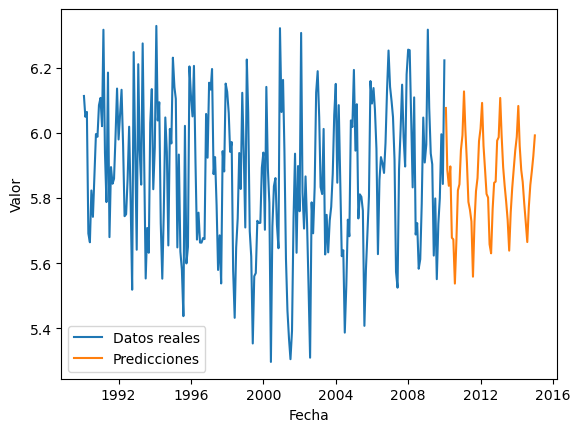

In [44]:
mae, mse = tsa.fit_predict_evaluate_plot(order=(0, 0, 2), seasonal_order=(5, 0, 2, 6), trend='c')

In [45]:
mae, mse

(331.04210260314153, 116187.96027497854)